In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import os, math, sys
from collections import Counter
from IPython.display import display
import subprocess
import pandas as pd
from itertools import groupby
from operator import itemgetter

from sklearn import model_selection

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
csv_directory = "/home/tushaar/Desktop/phishing_corpus/csv/"
feature_selection_csv_directory = "/home/tushaar/Desktop/phishing_corpus/feature_selection_csv/"

files = ['dataset_HP', 'dataset_HS', 'dataset_HSP']

In [4]:
def get_data(filename):
    filename = csv_directory + filename + '.csv'
    if os.path.exists(filename):
        df = pd.read_csv(filename)
    else:
        print "Run `feature_extraction.py` to get CSV"
    return df

filename = files[2]
df = get_data(filename)
display(df.head())
display(df.tail())

,body_forms,body_html,body_noCharacters,body_noDistinctWords,body_noFunctionWords,body_noWords,body_richness,body_suspension,body_verifyYourAccount,script_javaScript,...,url_noDomains,url_noExtLinks,url_noImgLinks,url_noIntLinks,url_noIpAddresses,url_noLinks,url_noPorts,url_nonModalHereLinks,url_ports,label
0,False,False,257,40,2,46,0.178988,False,False,False,...,2,1,0,0,0,1,0,False,False,S
1,False,False,579,65,3,77,0.132988,False,False,False,...,3,2,0,0,1,2,0,False,False,S
2,False,True,14972,1146,7,2395,0.159965,False,False,False,...,3,1,1,0,0,1,0,False,False,S
3,False,True,1042,127,3,174,0.166987,False,False,False,...,4,2,0,0,0,2,0,False,False,S
4,True,True,9205,427,4,968,0.105160,False,False,False,...,8,28,16,3,1,31,0,False,False,S


,body_forms,body_html,body_noCharacters,body_noDistinctWords,body_noFunctionWords,body_noWords,body_richness,body_suspension,body_verifyYourAccount,script_javaScript,...,url_noDomains,url_noExtLinks,url_noImgLinks,url_noIntLinks,url_noIpAddresses,url_noLinks,url_noPorts,url_nonModalHereLinks,url_ports,label
3839,False,True,38508,820,9,1296,0.033655,True,False,False,...,7,11,14,10,0,21,0,False,False,P
3840,False,True,10938,395,15,1165,0.106509,False,False,False,...,9,13,9,5,0,18,0,False,False,P
3841,False,True,1181,80,2,115,0.097375,False,False,False,...,3,1,0,1,0,2,0,False,False,P
3842,False,True,93089,1211,0,1215,0.013052,False,False,False,...,2,0,0,0,0,0,0,False,False,P
3843,False,True,10383,144,0,177,0.017047,False,False,False,...,2,0,0,12,0,12,0,False,False,P


In [5]:
def most_common_smallest(thresholds):
    most_common = dict(Counter(thresholds).most_common())
    most_common = sorted(most_common.items(), key = lambda x: (-x[1],x[0]))
    min_most_common = most_common[0][0]
    return min_most_common

def get_features(df):
    features = list(df.columns[:-1])
    return features

features = get_features(df)
display(features)
print len(features)

most_common = most_common_smallest([1.2, 1.2, 2.1, 2.1, 3.3, 3.3, 4])
print most_common

['body_forms',
 'body_html',
 'body_noCharacters',
 'body_noDistinctWords',
 'body_noFunctionWords',
 'body_noWords',
 'body_richness',
 'body_suspension',
 'body_verifyYourAccount',
 'script_javaScript',
 'script_noOnClickEvents',
 'script_nonModalJsLoads',
 'script_popups',
 'script_scripts',
 'script_statusChange',
 'send_diffSenderReplyTo',
 'send_noCharacters',
 'send_noWords',
 'send_nonModalSenderDomain',
 'subj_bank',
 'subj_debit',
 'subj_forward',
 'subj_noCharacters',
 'subj_noWords',
 'subj_reply',
 'subj_richness',
 'subj_verify',
 'url_atSymbol',
 'url_ipAddress',
 'url_linkText',
 'url_maxNoPeriods',
 'url_noDomains',
 'url_noExtLinks',
 'url_noImgLinks',
 'url_noIntLinks',
 'url_noIpAddresses',
 'url_noLinks',
 'url_noPorts',
 'url_nonModalHereLinks',
 'url_ports']

40
1.2


In [5]:
def normalization(entries):
    entries = entries * 1       # Convert boolean to integer
    min_value = min(entries)
    max_value = max(entries)
    if min_value != max_value:
        entries = [float(entry - min_value) / (max_value - min_value) for entry in entries]
    return entries

def get_variance(df, column):
    column_entries = df[column]
    column_entries = normalization(column_entries)
    # print column_entries
    mean = sum(column_entries) / float(len(column_entries))
    variance = sum([(x - mean) ** 2 for x in column_entries]) / float(len(column_entries))
    return variance

variance = get_variance(df, features[0])
print variance

0.00535380085163


In [6]:
'''
Ensemble Based: Bagging Algorithms
'''

def bagged_decision_tree(df, label, k_fold = None):
    features = get_features(df)
    y = df[label]
    X = df[features]
    
    seed = 1
    folds = 10
    if k_fold is not None:
        folds = k_fold
    kfold = model_selection.KFold(n_splits = folds, random_state = seed)
    cart = DecisionTreeClassifier()
    num_trees = 10
    model = BaggingClassifier(base_estimator = cart, n_estimators = num_trees, random_state = seed)
    results = model_selection.cross_val_score(model, X, y, cv = kfold)
    return (results.mean()) * 100

def random_forest(df, label, k_fold = None):
    features = get_features(df)
    y = df[label]
    X = df[features]
    
    seed = 1
    num_trees = 10
    folds = 10
    if k_fold is not None:
        folds = k_fold
    kfold = model_selection.KFold(n_splits = folds, random_state = seed)
    model = RandomForestClassifier(n_estimators = num_trees)
    results = model_selection.cross_val_score(model, X, y, cv = kfold)
    return (results.mean()) * 100

def extra_trees(df, label, k_fold = None):
    features = get_features(df)
    y = df[label]
    X = df[features]
    
    seed = 1
    num_trees = 10
    folds = 10
    if k_fold is not None:
        folds = k_fold
    kfold = model_selection.KFold(n_splits = folds, random_state = seed)
    model = ExtraTreesClassifier(n_estimators = num_trees)
    results = model_selection.cross_val_score(model, X, y, cv = kfold)
    return (results.mean()) * 100

In [7]:
'''
Ensemble Based: Boosting Algorithms
'''

def adaboost(df, label, k_fold = None):
    features = get_features(df)
    y = df[label]
    X = df[features]
    
    seed = 1
    num_trees = 10
    folds = 10
    if k_fold is not None:
        folds = k_fold
    kfold = model_selection.KFold(n_splits = folds, random_state = seed)
    model = AdaBoostClassifier(n_estimators = num_trees, random_state = seed)
    results = model_selection.cross_val_score(model, X, y, cv = kfold)
    return (results.mean()) * 100

def stochastic_gradient_boosting(df, label, k_fold = None):
    features = get_features(df)
    y = df[label]
    X = df[features]
    
    seed = 1
    num_trees = 10
    folds = 10
    if k_fold is not None:
        folds = k_fold
    kfold = model_selection.KFold(n_splits = folds, random_state = seed)
    model = GradientBoostingClassifier(n_estimators = num_trees, random_state = seed)
    results = model_selection.cross_val_score(model, X, y, cv = kfold)
    return (results.mean()) * 100

In [8]:
'''
Ensemble Based: Voting
'''

def voting_ensemble(df, label, k_fold = None):
    features = get_features(df)
    y = df[label]
    X = df[features]
    
    seed = 1
    folds = 10
    if k_fold is not None:
        folds = k_fold
    kfold = model_selection.KFold(n_splits = folds, random_state = seed)
    
    estimators = []
    estimators.append(('cart', DecisionTreeClassifier()))
    estimators.append(('random_forest', RandomForestClassifier()))
    estimators.append(('adaboost', AdaBoostClassifier()))
    estimators.append(('svm', SVC()))
    estimators.append(('naive_bayes', GaussianNB()))
    estimators.append(('LDA', LinearDiscriminantAnalysis()))

    ensemble = VotingClassifier(estimators)
    results = model_selection.cross_val_score(ensemble, X, y, cv = kfold)
    return (results.mean()) * 100

In [9]:
'''
Algorithms used in mRMR 
'''

def naive_bayes(df, label, k_fold = None):
    features = get_features(df)
    y = df[label]
    X = df[features]
    
    seed = 1
    folds = 10
    if k_fold is not None:
        folds = k_fold
    kfold = model_selection.KFold(n_splits = folds, random_state = seed)
    model = GaussianNB()
    results = model_selection.cross_val_score(model, X, y, cv = kfold)
    return (results.mean()) * 100
    
def SVM(df, label, k_fold = None):
    features = get_features(df)
    y = df[label]
    X = df[features]
    
    seed = 1
    folds = 10
    if k_fold is not None:
        folds = k_fold
    kfold = model_selection.KFold(n_splits = folds, random_state = seed)
    model = SVC()
    results = model_selection.cross_val_score(model, X, y, cv = kfold)
    return (results.mean()) * 100

In [10]:
algorithms = [bagged_decision_tree, random_forest, extra_trees, adaboost, stochastic_gradient_boosting, voting_ensemble]
mRMR_algorithms = [naive_bayes, SVM]

In [11]:
def compute_accuracies(df, label, algorithms, k_fold = None):
    accuracies = {}
    for algorithm in algorithms:
        accuracy = algorithm(df, label, k_fold)
        # print "* Algorithm, Accuracy = (%s, %s)" %(algorithm.__name__, accuracy)
        accuracies[algorithm.__name__] = accuracy
    return accuracies

accuracies = compute_accuracies(df, 'label', algorithms)
display(accuracies)

accuracies = compute_accuracies(df, 'label', mRMR_algorithms)
display(accuracies)

/home/tushaar/venv/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/home/tushaar/venv/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


{'adaboost': 84.509199134199136,
 'bagged_decision_tree': 89.524215367965382,
 'extra_trees': 91.189799783549788,
 'random_forest': 90.41051136363636,
 'stochastic_gradient_boosting': 84.953327922077932,
 'voting_ensemble': 85.886904761904773}

{'SVM': 68.176812770562762, 'naive_bayes': 72.831304112554122}

In [11]:
'''
Silipo, R., Adae, I., & Hart, A. (2015). Seven techniques for data dimensionality reduction.

Shams, R., & Mercer, R. E. (2013, December). Classifying spam emails using text and readability features. 
In Data Mining (ICDM), 2013 IEEE 13th International Conference on (pp. 657-666). IEEE.
'''

print "* Original features (variance):"
features = get_features(df)
for feature in features:
    print get_variance(df, feature)

def var_algorithm_best_threshold(df, label, algorithm):
    threshold = 0.01
    accuracy = 0.0
    while threshold <= 0.1:
        df_copy = df.copy()
        features = get_features(df)
        for feature in features:
            variance = get_variance(df, feature)
            if variance < threshold:
                del df_copy[feature]
        result = algorithm(df_copy, label)
        # print "* Threshold, Accuracy, Features = (%s, %s, %s)" %(threshold, result, len(list(df_copy.columns[:-1])))
        if accuracy < result:
            accuracy = result
            best_threshold = threshold
            df_final = df_copy
        threshold = threshold + 0.01
    return best_threshold, df_final, accuracy

def var_get_best_threshold(df, label, algorithms):
    thresholds = []
    dfs = []
    for algorithm in algorithms:
        # print "* Algorithm = %s" %algorithm.__name__
        threshold, df, accuracy = var_algorithm_best_threshold(df, label, algorithm)
        thresholds.append(threshold)
        dfs.append(df)
        # print "* Best Threshold = %s" %threshold
    min_best_threshold = most_common_smallest(thresholds)
    index = thresholds.index(min_best_threshold)
    return min_best_threshold, dfs[index]

best_threshold, df_low_var_filter = var_get_best_threshold(df, 'label', algorithms)
print "* Optimal Threshold: %s" %best_threshold
display(df_low_var_filter.head())
display(df_low_var_filter.tail())

print "* Reduced features (variance):"
features = get_features(df_low_var_filter)
for feature in features:
    print get_variance(df_low_var_filter, feature)
print "* Reduced dimension: %s" %len(features)

* Original features (variance):
0.00535380085163
0.243432409829
0.000732899556894
0.000615419742251
0.00360482076254
0.00119991305194
0.0401161441235
0.0118186396832
0.0124020598201
0.000298953635448
0.00119474142076
0.0029814879467
0.00208891952451
0.00683068367826
0.0
0.137020386438
0.0106543378255
0.0196617410212
0.0925258371775
0.00859704090451
0.00059772841739
0.000896324345825
0.0159520738625
0.0120839855426
0.2321317299
0.00301739274408
0.00624046710812
0.0298527069836
0.00476179574643
0.0767209999771
0.0162623632376
0.00490348866085
0.00216821446656
0.00242516913234
0.00113365975533
0.00476179574643
0.00181451474528
0.00102565530335
0.0227812864861
0.00446552491358
* Optimal Threshold: 0.01


,body_html,body_richness,body_suspension,body_verifyYourAccount,send_diffSenderReplyTo,send_noCharacters,send_noWords,send_nonModalSenderDomain,subj_noCharacters,subj_noWords,subj_reply,url_atSymbol,url_linkText,url_maxNoPeriods,url_nonModalHereLinks,label
0,True,0.119686,False,False,False,37,4,True,19,2,False,False,False,3,False,P
1,True,0.054039,False,False,False,33,3,True,39,8,False,False,True,3,False,P
2,True,0.013004,False,False,False,41,2,False,60,13,False,False,False,0,False,P
3,True,0.041579,False,True,False,37,2,True,34,7,False,False,False,0,False,P
4,True,0.101166,False,False,False,58,4,True,45,6,False,False,True,2,False,P


,body_html,body_richness,body_suspension,body_verifyYourAccount,send_diffSenderReplyTo,send_noCharacters,send_noWords,send_nonModalSenderDomain,subj_noCharacters,subj_noWords,subj_reply,url_atSymbol,url_linkText,url_maxNoPeriods,url_nonModalHereLinks,label
3339,True,0.033655,True,False,False,32,2,True,43,11,False,True,True,4,False,P
3340,True,0.106509,False,False,False,32,2,True,21,4,False,False,True,4,False,P
3341,True,0.097375,False,False,False,38,4,True,16,2,True,False,False,3,False,P
3342,True,0.013052,False,False,False,30,2,False,33,9,False,False,False,0,False,P
3343,True,0.017047,False,False,False,72,2,True,16,2,False,False,False,3,False,P


* Reduced features (variance):
0.243432409829
0.0401161441235
0.0118186396832
0.0124020598201
0.137020386438
0.0106543378255
0.0196617410212
0.0925258371775
0.0159520738625
0.0120839855426
0.2321317299
0.0298527069836
0.0767209999771
0.0162623632376
0.0227812864861
* Reduced dimension: 15


In [12]:
def low_variance_filter(df, label, algorithms):
    best_threshold, df_low_var_filter = var_get_best_threshold(df, label, algorithms)
    accuracies = compute_accuracies(df_low_var_filter, label, algorithms)
    return df_low_var_filter, accuracies

df_low_var_filter, accuracies = low_variance_filter(df, 'label', algorithms)
display(df_low_var_filter.head())
display(df_low_var_filter.tail())
display(accuracies)

,body_html,body_richness,body_suspension,body_verifyYourAccount,send_diffSenderReplyTo,send_noCharacters,send_noWords,send_nonModalSenderDomain,subj_noCharacters,subj_noWords,subj_reply,url_atSymbol,url_linkText,url_maxNoPeriods,url_nonModalHereLinks,label
0,True,0.119686,False,False,False,37,4,True,19,2,False,False,False,3,False,P
1,True,0.054039,False,False,False,33,3,True,39,8,False,False,True,3,False,P
2,True,0.013004,False,False,False,41,2,False,60,13,False,False,False,0,False,P
3,True,0.041579,False,True,False,37,2,True,34,7,False,False,False,0,False,P
4,True,0.101166,False,False,False,58,4,True,45,6,False,False,True,2,False,P


,body_html,body_richness,body_suspension,body_verifyYourAccount,send_diffSenderReplyTo,send_noCharacters,send_noWords,send_nonModalSenderDomain,subj_noCharacters,subj_noWords,subj_reply,url_atSymbol,url_linkText,url_maxNoPeriods,url_nonModalHereLinks,label
3339,True,0.033655,True,False,False,32,2,True,43,11,False,True,True,4,False,P
3340,True,0.106509,False,False,False,32,2,True,21,4,False,False,True,4,False,P
3341,True,0.097375,False,False,False,38,4,True,16,2,True,False,False,3,False,P
3342,True,0.013052,False,False,False,30,2,False,33,9,False,False,False,0,False,P
3343,True,0.017047,False,False,False,72,2,True,16,2,False,False,False,3,False,P


{'adaboost': 95.0656895164894,
 'bagged_decision_tree': 96.352489051747241,
 'extra_trees': 97.100455804808306,
 'random_forest': 96.980874072750041,
 'stochastic_gradient_boosting': 95.514523192421137,
 'voting_ensemble': 95.8442220037537}

In [13]:
def remove_correlated(df, threshold):
    df_copy = df.copy()
    corr_columns = set()
    corr_matrix = df_copy.corr()
    # print corr_matrix
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                column = corr_matrix.columns[i]
                corr_columns.add(column)
                if column in df_copy.columns:
                    del df_copy[column]
    return df_copy

df_low_corr_filter = remove_correlated(df, 0.8)
display(df_low_corr_filter.head())
display(df_low_corr_filter.tail())
print "* Reduced dimension: %s" %len(get_features(df_low_corr_filter))

,body_forms,body_html,body_noCharacters,body_noFunctionWords,body_richness,body_suspension,body_verifyYourAccount,script_javaScript,script_noOnClickEvents,script_nonModalJsLoads,...,url_ipAddress,url_linkText,url_maxNoPeriods,url_noDomains,url_noExtLinks,url_noImgLinks,url_noIntLinks,url_noPorts,url_nonModalHereLinks,label
0,False,True,1529,16,0.119686,False,False,False,0,False,...,False,False,3,5,3,3,1,0,False,P
1,False,True,5311,5,0.054039,False,False,False,0,False,...,True,True,3,7,10,8,1,0,False,P
2,False,True,358130,0,0.013004,False,False,False,0,False,...,False,False,0,2,0,0,0,0,False,P
3,False,True,5700,18,0.041579,False,True,False,0,False,...,False,False,0,3,1,0,2,0,False,P
4,False,True,8234,12,0.101166,False,False,False,0,False,...,False,True,2,4,2,0,2,0,False,P


,body_forms,body_html,body_noCharacters,body_noFunctionWords,body_richness,body_suspension,body_verifyYourAccount,script_javaScript,script_noOnClickEvents,script_nonModalJsLoads,...,url_ipAddress,url_linkText,url_maxNoPeriods,url_noDomains,url_noExtLinks,url_noImgLinks,url_noIntLinks,url_noPorts,url_nonModalHereLinks,label
3339,False,True,38508,9,0.033655,True,False,False,0,False,...,False,True,4,7,11,14,10,0,False,P
3340,False,True,10938,15,0.106509,False,False,False,0,False,...,False,True,4,9,13,9,5,0,False,P
3341,False,True,1181,2,0.097375,False,False,False,0,False,...,False,False,3,3,1,0,1,0,False,P
3342,False,True,93089,0,0.013052,False,False,False,0,False,...,False,False,0,2,0,0,0,0,False,P
3343,False,True,10383,0,0.017047,False,False,False,0,False,...,False,False,3,2,0,0,12,0,False,P


* Reduced dimension: 34


In [14]:
def corr_algorithm_best_threshold(df, label, algorithm):
    threshold = 0.0
    accuracy = 0.0
    while threshold <= 1.0:
        df_copy = df.copy()
        df_copy = remove_correlated(df_copy, threshold)
        result = algorithm(df_copy, label)
        # print "* Threshold, Accuracy, Features = (%s, %s, %s)" %(threshold, result, len(list(df_copy.columns[:-1])))
        if accuracy < result:
            accuracy = result
            best_threshold = threshold
            df_final = df_copy
        threshold = threshold + 0.1
    return best_threshold, df_final, accuracy

def corr_get_best_threshold(df, label, algorithms):
    thresholds = []
    dfs = []
    for algorithm in algorithms:
        # print "* Algorithm = %s" %algorithm.__name__
        threshold, df, accuracy = corr_algorithm_best_threshold(df, label, algorithm)
        thresholds.append(threshold)
        dfs.append(df)
        # print "* Best Threshold = %s" %threshold
    min_best_threshold = most_common_smallest(thresholds)
    index = thresholds.index(min_best_threshold)
    return min_best_threshold, dfs[index]

best_threshold, df_low_corr_filter = corr_get_best_threshold(df, 'label', algorithms)
print "* Optimal Threshold: %s" %best_threshold
display(df_low_corr_filter.head())
display(df_low_corr_filter.tail())
print "* Reduced dimension: %s" %len(get_features(df_low_corr_filter))

* Optimal Threshold: 0.5


,body_forms,body_html,body_noCharacters,body_noFunctionWords,body_richness,body_suspension,body_verifyYourAccount,script_javaScript,script_noOnClickEvents,script_statusChange,...,subj_verify,url_atSymbol,url_ipAddress,url_linkText,url_maxNoPeriods,url_noDomains,url_noImgLinks,url_noPorts,url_nonModalHereLinks,label
0,False,True,1529,16,0.119686,False,False,False,0,False,...,False,False,False,False,3,5,3,0,False,P
1,False,True,5311,5,0.054039,False,False,False,0,False,...,False,False,True,True,3,7,8,0,False,P
2,False,True,358130,0,0.013004,False,False,False,0,False,...,False,False,False,False,0,2,0,0,False,P
3,False,True,5700,18,0.041579,False,True,False,0,False,...,False,False,False,False,0,3,0,0,False,P
4,False,True,8234,12,0.101166,False,False,False,0,False,...,False,False,False,True,2,4,0,0,False,P


,body_forms,body_html,body_noCharacters,body_noFunctionWords,body_richness,body_suspension,body_verifyYourAccount,script_javaScript,script_noOnClickEvents,script_statusChange,...,subj_verify,url_atSymbol,url_ipAddress,url_linkText,url_maxNoPeriods,url_noDomains,url_noImgLinks,url_noPorts,url_nonModalHereLinks,label
3339,False,True,38508,9,0.033655,True,False,False,0,False,...,False,True,False,True,4,7,14,0,False,P
3340,False,True,10938,15,0.106509,False,False,False,0,False,...,False,False,False,True,4,9,9,0,False,P
3341,False,True,1181,2,0.097375,False,False,False,0,False,...,False,False,False,False,3,3,0,0,False,P
3342,False,True,93089,0,0.013052,False,False,False,0,False,...,False,False,False,False,0,2,0,0,False,P
3343,False,True,10383,0,0.017047,False,False,False,0,False,...,False,False,False,False,3,2,0,0,False,P


* Reduced dimension: 29


In [15]:
def low_correlation_filter(df, label, algorithms):
    best_threshold, df_low_corr_filter = corr_get_best_threshold(df, label, algorithms)
    accuracies = compute_accuracies(df_low_corr_filter, label, algorithms)
    return df_low_corr_filter, accuracies

df_low_corr_filter, accuracies = low_correlation_filter(df, 'label', algorithms)
display(df_low_corr_filter.head())
display(df_low_corr_filter.tail())
display(accuracies)

,body_forms,body_html,body_noCharacters,body_noFunctionWords,body_richness,body_suspension,body_verifyYourAccount,script_javaScript,script_noOnClickEvents,script_statusChange,...,subj_verify,url_atSymbol,url_ipAddress,url_linkText,url_maxNoPeriods,url_noDomains,url_noImgLinks,url_noPorts,url_nonModalHereLinks,label
0,False,True,1529,16,0.119686,False,False,False,0,False,...,False,False,False,False,3,5,3,0,False,P
1,False,True,5311,5,0.054039,False,False,False,0,False,...,False,False,True,True,3,7,8,0,False,P
2,False,True,358130,0,0.013004,False,False,False,0,False,...,False,False,False,False,0,2,0,0,False,P
3,False,True,5700,18,0.041579,False,True,False,0,False,...,False,False,False,False,0,3,0,0,False,P
4,False,True,8234,12,0.101166,False,False,False,0,False,...,False,False,False,True,2,4,0,0,False,P


,body_forms,body_html,body_noCharacters,body_noFunctionWords,body_richness,body_suspension,body_verifyYourAccount,script_javaScript,script_noOnClickEvents,script_statusChange,...,subj_verify,url_atSymbol,url_ipAddress,url_linkText,url_maxNoPeriods,url_noDomains,url_noImgLinks,url_noPorts,url_nonModalHereLinks,label
3339,False,True,38508,9,0.033655,True,False,False,0,False,...,False,True,False,True,4,7,14,0,False,P
3340,False,True,10938,15,0.106509,False,False,False,0,False,...,False,False,False,True,4,9,9,0,False,P
3341,False,True,1181,2,0.097375,False,False,False,0,False,...,False,False,False,False,3,3,0,0,False,P
3342,False,True,93089,0,0.013052,False,False,False,0,False,...,False,False,False,False,0,2,0,0,False,P
3343,False,True,10383,0,0.017047,False,False,False,0,False,...,False,False,False,False,3,2,0,0,False,P


{'adaboost': 96.323085172937709,
 'bagged_decision_tree': 98.23603539190276,
 'extra_trees': 97.787827330413805,
 'random_forest': 97.937259808740734,
 'stochastic_gradient_boosting': 95.515685047814827,
 'voting_ensemble': 96.980516578782726}

In [16]:
def feature_importance(df, label):
    importances = {}
    features = get_features(df)
    y = df[label]
    X = df[features]

    model = RandomForestClassifier(n_estimators = 10, random_state = 1)
    model.fit(X, y)
    for name, importance in zip(X.columns, model.feature_importances_):
        importances[name] = importance
    return importances

def removal_using_importance(df, label):
    df_copy = df.copy()
    remove_columns = set()
    importances = feature_importance(df, 'label')
    for feature, importance in importances.iteritems():
        if importance == 0:
            remove_columns.add(feature)
    # display(remove_columns)
    
    for column in df.columns:
        if column in remove_columns:
            del df_copy[column]
    return df_copy

df_no_imp_filter = removal_using_importance(df, 'label')
display(df_no_imp_filter.head())
display(df_no_imp_filter.tail())

,body_forms,body_html,body_noCharacters,body_noDistinctWords,body_noFunctionWords,body_noWords,body_richness,body_suspension,body_verifyYourAccount,send_diffSenderReplyTo,...,url_noDomains,url_noExtLinks,url_noImgLinks,url_noIntLinks,url_noIpAddresses,url_noLinks,url_noPorts,url_nonModalHereLinks,url_ports,label
0,False,True,1529,104,16,183,0.119686,False,False,False,...,5,3,3,1,0,4,0,False,False,P
1,False,True,5311,214,5,287,0.054039,False,False,False,...,7,10,8,1,1,11,0,False,False,P
2,False,True,358130,4646,0,4657,0.013004,False,False,False,...,2,0,0,0,0,0,0,False,False,P
3,False,True,5700,173,18,237,0.041579,False,True,False,...,3,1,0,2,0,3,0,False,False,P
4,False,True,8234,277,12,833,0.101166,False,False,False,...,4,2,0,2,0,4,0,False,False,P


,body_forms,body_html,body_noCharacters,body_noDistinctWords,body_noFunctionWords,body_noWords,body_richness,body_suspension,body_verifyYourAccount,send_diffSenderReplyTo,...,url_noDomains,url_noExtLinks,url_noImgLinks,url_noIntLinks,url_noIpAddresses,url_noLinks,url_noPorts,url_nonModalHereLinks,url_ports,label
3339,False,True,38508,820,9,1296,0.033655,True,False,False,...,7,11,14,10,0,21,0,False,False,P
3340,False,True,10938,395,15,1165,0.106509,False,False,False,...,9,13,9,5,0,18,0,False,False,P
3341,False,True,1181,80,2,115,0.097375,False,False,False,...,3,1,0,1,0,2,0,False,False,P
3342,False,True,93089,1211,0,1215,0.013052,False,False,False,...,2,0,0,0,0,0,0,False,False,P
3343,False,True,10383,144,0,177,0.017047,False,False,False,...,2,0,0,12,0,12,0,False,False,P


In [17]:
def no_importance_filter(df, label, algorithms):
    df_no_imp_filter = removal_using_importance(df, label)
    accuracies = compute_accuracies(df_no_imp_filter, label, algorithms)
    return df_no_imp_filter, accuracies

df_no_imp_filter, accuracies = no_importance_filter(df, 'label', algorithms)
display(df_no_imp_filter.head())
display(df_no_imp_filter.tail())
display(accuracies)

,body_forms,body_html,body_noCharacters,body_noDistinctWords,body_noFunctionWords,body_noWords,body_richness,body_suspension,body_verifyYourAccount,send_diffSenderReplyTo,...,url_noDomains,url_noExtLinks,url_noImgLinks,url_noIntLinks,url_noIpAddresses,url_noLinks,url_noPorts,url_nonModalHereLinks,url_ports,label
0,False,True,1529,104,16,183,0.119686,False,False,False,...,5,3,3,1,0,4,0,False,False,P
1,False,True,5311,214,5,287,0.054039,False,False,False,...,7,10,8,1,1,11,0,False,False,P
2,False,True,358130,4646,0,4657,0.013004,False,False,False,...,2,0,0,0,0,0,0,False,False,P
3,False,True,5700,173,18,237,0.041579,False,True,False,...,3,1,0,2,0,3,0,False,False,P
4,False,True,8234,277,12,833,0.101166,False,False,False,...,4,2,0,2,0,4,0,False,False,P


,body_forms,body_html,body_noCharacters,body_noDistinctWords,body_noFunctionWords,body_noWords,body_richness,body_suspension,body_verifyYourAccount,send_diffSenderReplyTo,...,url_noDomains,url_noExtLinks,url_noImgLinks,url_noIntLinks,url_noIpAddresses,url_noLinks,url_noPorts,url_nonModalHereLinks,url_ports,label
3339,False,True,38508,820,9,1296,0.033655,True,False,False,...,7,11,14,10,0,21,0,False,False,P
3340,False,True,10938,395,15,1165,0.106509,False,False,False,...,9,13,9,5,0,18,0,False,False,P
3341,False,True,1181,80,2,115,0.097375,False,False,False,...,3,1,0,1,0,2,0,False,False,P
3342,False,True,93089,1211,0,1215,0.013052,False,False,False,...,2,0,0,0,0,0,0,False,False,P
3343,False,True,10383,144,0,177,0.017047,False,False,False,...,2,0,0,12,0,12,0,False,False,P


{'adaboost': 96.083296094378397,
 'bagged_decision_tree': 98.026454553579413,
 'extra_trees': 98.355349003485571,
 'random_forest': 98.504960228796151,
 'stochastic_gradient_boosting': 95.695057645902239,
 'voting_ensemble': 97.24970953615157}

In [12]:
'''
Peng, H., Long, F., & Ding, C. (2005). Feature selection based on mutual information criteria of max-dependency, max-relevance, and min-redundancy. 
IEEE Transactions on pattern analysis and machine intelligence, 27(8), 1226-1238.
'''

def attribute_types(df, attribute):
    return df[attribute].unique()

def preprocessing(df, label_column):
    transformed_df = df.copy()
    labels = attribute_types(df, label_column)
    mapping = {name : number for number, name in enumerate(labels)}
    transformed_df['label'] = transformed_df[label_column].replace(mapping)
    return mapping, transformed_df

mapping, transformed_df = preprocessing(df, 'label')
display(transformed_df.head())
display(mapping)

,body_forms,body_html,body_noCharacters,body_noDistinctWords,body_noFunctionWords,body_noWords,body_richness,body_suspension,body_verifyYourAccount,script_javaScript,...,url_noDomains,url_noExtLinks,url_noImgLinks,url_noIntLinks,url_noIpAddresses,url_noLinks,url_noPorts,url_nonModalHereLinks,url_ports,label
0,False,False,257,40,2,46,0.178988,False,False,False,...,2,1,0,0,0,1,0,False,False,0
1,False,False,579,65,3,77,0.132988,False,False,False,...,3,2,0,0,1,2,0,False,False,0
2,False,True,14972,1146,7,2395,0.159965,False,False,False,...,3,1,1,0,0,1,0,False,False,0
3,False,True,1042,127,3,174,0.166987,False,False,False,...,4,2,0,0,0,2,0,False,False,0
4,True,True,9205,427,4,968,0.105160,False,False,False,...,8,28,16,3,1,31,0,False,False,0


{'H': 2, 'P': 1, 'S': 0}

In [13]:
def freedman_diaconis_bins(values):
    n = len(values)
    IQR = np.percentile(values, 75, interpolation='higher') - np.percentile(values, 25, interpolation='lower')
    h = float(2 * IQR) / (n ** (1.0/3))
    if h == 0 or max(values) == min(values):
        return 0
    
    bins = (max(values) - min(values))/ float(h)
    return int(bins)

values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
bins = freedman_diaconis_bins(values)
print bins
    
def get_data_mode(column, mapping):
    if type(column[0]) == bool:
        return "bool_discrete"
    elif len(np.unique(column)) == len(mapping):
        return "label_discrete"
    return "continuous"

def shannon_entropy(column):
    normalized_column = column/float(np.sum(column))
    normalized_column = normalized_column[np.nonzero(normalized_column)]
    H = -normalized_column.dot(np.log2(normalized_column))
    return H

def mutual_information(x, y, bins):
    xy = np.histogram2d(x, y, bins)[0]
    x = np.histogram(x, bins)[0]
    y = np.histogram(y, bins)[0]
    
    H_x = shannon_entropy(x)
    H_y = shannon_entropy(y)
    H_xy = shannon_entropy(xy) 
    
    I_xy = H_x + H_y - H_xy
    return I_xy

def get_information_matrix(df, mapping):
    df_np = df.as_matrix()
    n = df_np.shape[1]
    # print df_np[0]
    information_matrix = np.zeros((n, n))
    
    for i in np.arange(n):
        for j in np.arange(i + 1, n):    
            x_mode = get_data_mode(df_np[:, i], mapping)
            y_mode = get_data_mode(df_np[:, j], mapping)
            
            if x_mode == "continuous" or y_mode == "continuous":
                x_bins = 0
                y_bins = 0
                
                if x_mode == "continuous":
                    x_bins = freedman_diaconis_bins(df_np[:, i].astype(float))
                if y_mode == "continuous":
                    y_bins = freedman_diaconis_bins(df_np[:, j].astype(float))
                
                
                if x_bins == 0 and y_bins == 0:
                    bins = len(mapping)
                elif y_bins == 0:
                    bins = x_bins
                elif x_bins == 0:
                    bins = y_bins
                else:
                    bins = min(x_bins, y_bins)
            elif x_mode == "bool_discrete" and y_mode == "bool_discrete":
                bins = 2
            elif x_mode == "label_discrete" or y_mode == "label_discrete":
                bins = len(mapping)
            
            information_matrix[i, j] = mutual_information(df_np[:, i].astype(float), df_np[:, j].astype(float), bins)
            
    return information_matrix

mapping, transformed_df = preprocessing(df, 'label')
# print len(mapping)
# bins = 5
information_matrix = get_information_matrix(transformed_df, mapping)
print information_matrix

2
[[  0.00000000e+00   2.21529239e-02   7.32285831e-02 ...,   3.17835061e-04
    2.45893439e-04   3.37988613e-02]
 [  0.00000000e+00   0.00000000e+00   2.32181440e-01 ...,   4.89965496e-02
    4.31010339e-04   1.74399305e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   5.42587300e-02
    1.37831244e-02   3.71954055e-01]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    5.40379763e-04   6.47702837e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.09006012e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


In [14]:
def incremental_search(information_matrix, S_prev):
    m = len(S_prev) + 1
    n = information_matrix.shape[0]
    
    # print m
    # print n
    
    Xj = np.delete(np.arange(n - 1), S_prev)
    # print Xj
    
    S_add = -1
    max_phi = float("-inf")
    for j in Xj:
        information_sum = 0
        for i in S_prev:
            # print information_matrix[j, i]
            information_sum = information_sum + information_matrix[j, i]
        # print information_sum
        information = information_matrix[j, n - 1] - (information_sum/ float(m - 1))
        
        # print information, max_phi
        if information > max_phi:
            max_phi = information
            S_add = j
    
    if S_add != -1:
        S_new = np.concatenate([S_prev, [S_add]])
        return S_new

test_np = np.array([['A', 'B', 'C', 'D', 'label'],
                    [True, 25, 3.88, 56.44, 0],
                    [False, 36, 2.94, 63.54, 1],
                    [False, 42, 5.12, 44.79, 0],
                    [True, 60, 1.86, 38.23, 1]], dtype = object)
test_df = pd.DataFrame(data = test_np[1:,0:], columns = test_np[0,0:]) 
display(test_df.head())

mapping = {'S' : 1, 'P' : 0}
test_information_matrix = get_information_matrix(test_df, mapping)
print test_information_matrix

S_prev = np.array([0, 3])
S_new = incremental_search(test_information_matrix, S_prev)
print S_new

n = test_information_matrix.shape[0]
max_info = max(test_information_matrix[:, n - 1])
print np.where(test_information_matrix == max_info)[0]

,A,B,C,D,label
0,True,25,3.88,56.44,0
1,False,36,2.94,63.54,1
2,False,42,5.12,44.79,0
3,True,60,1.86,38.23,1


[[ 0.          0.31127812  0.          0.          0.        ]
 [ 0.          0.          0.31127812  0.31127812  0.31127812]
 [ 0.          0.          0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[0 3 2]
[2]


In [20]:
def get_all_feature_sets(information_matrix):
    n = information_matrix.shape[0]
    feature_sets = []
    
    max_info = max(information_matrix[:, n - 1])
    S_prev = np.where(information_matrix == max_info)[0]
    # print S_prev
    feature_sets.append(S_prev)
    for m in range(1, n - 1):
        # print S_prev
        S_new = incremental_search(information_matrix, S_prev)
        feature_sets.append(S_new)
        S_prev = S_new
    
    return feature_sets

print test_information_matrix
feature_sets = get_all_feature_sets(test_information_matrix)
print feature_sets

[[ 0.          0.31127812  0.          0.          0.        ]
 [ 0.          0.          0.31127812  0.31127812  0.31127812]
 [ 0.          0.          0.          0.          1.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[array([2]), array([2, 0]), array([2, 0, 1]), array([2, 0, 1, 3])]


In [22]:
def cross_validation_error_average(accuracies):
    count = 0
    total = 0.0
    for key in accuracies:
        count = count + 1
        error = 1 - (accuracies[key]/100)
        total = total + error
    return total/float(count)

def get_sigma_set(df, feature_sets, benchmark_algorithms, label, k_fold = None):
    sigma = {}
    index = 0
    for feature_set in feature_sets:
        feature_set = np.concatenate([feature_set, [len(feature_sets)]])
        mRMR_df = df.iloc[:, feature_set]
        accuracies = compute_accuracies(mRMR_df, label, benchmark_algorithms, k_fold)
        # print accuracies
        sigma[index] = cross_validation_error_average(accuracies)
        # print sigma[index]
        index = index + 1
    return sigma

feature_sets = get_all_feature_sets(information_matrix)
benchmark_algorithms = [voting_ensemble]
sigma = get_sigma_set(df, feature_sets, benchmark_algorithms, 'label')
print sigma

{'voting_ensemble': 75.433306277056275}
{'voting_ensemble': 76.655573593073598}
{'voting_ensemble': 82.770156926406926}
{'voting_ensemble': 83.029964826839816}
{'voting_ensemble': 83.965165043290028}
{'voting_ensemble': 84.953327922077932}
{'voting_ensemble': 82.067843614718612}
{'voting_ensemble': 81.859983766233782}
{'voting_ensemble': 82.587459415584405}
{'voting_ensemble': 82.795116341991346}
{'voting_ensemble': 83.522591991341983}
{'voting_ensemble': 84.847740800865807}
{'voting_ensemble': 84.873985389610382}
{'voting_ensemble': 84.613839285714278}
{'voting_ensemble': 84.61404220779221}
{'voting_ensemble': 85.10808982683983}
{'voting_ensemble': 85.966247294372309}
{'voting_ensemble': 85.940070346320354}
{'voting_ensemble': 85.55032467532466}
{'voting_ensemble': 85.550054112554122}
{'voting_ensemble': 86.48606601731602}
{'voting_ensemble': 86.226325757575765}
{'voting_ensemble': 86.226325757575765}
{'voting_ensemble': 86.070278679653683}
{'voting_ensemble': 86.459686147186147}
{'vo

In [23]:
def get_mRMR_feature_set(df, feature_sets, sigma):
    indices = [v for k, v in groupby(sorted((v,k) for k,v in sigma.iteritems()), 
                                     key = itemgetter(0)).next()[1]]
    possible_sets = []
    for index in indices:
        possible_sets.append(list(feature_sets[index]))
    mRMR_feature_set = min(possible_sets, key = len)
    mRMR_feature_set.append(len(get_features(df)))
    return mRMR_feature_set

mRMR_feature_set = get_mRMR_feature_set(df, feature_sets, sigma)
print mRMR_feature_set

def get_df_from_mRMR(df, mRMR_feature_set):
    mRMR_df = df.iloc[:, mRMR_feature_set]
    return mRMR_df

mRMR_df = get_df_from_mRMR(df, mRMR_feature_set)
display(mRMR_df.head())

[4, 34, 6, 36, 29, 16, 2, 24, 17, 38, 35, 1, 27, 5, 25, 30, 31, 28, 8, 7, 32, 39, 26, 0, 13, 19, 23, 37, 21, 20, 3, 11, 12, 15, 9, 14, 40]


,body_noFunctionWords,url_noIntLinks,body_richness,url_noLinks,url_linkText,send_noCharacters,body_noCharacters,subj_reply,send_noWords,url_nonModalHereLinks,...,url_noPorts,subj_forward,subj_debit,body_noDistinctWords,script_nonModalJsLoads,script_popups,send_diffSenderReplyTo,script_javaScript,script_statusChange,label
0,2,0,0.178988,1,False,35,257,False,3,False,...,0,False,False,40,False,False,False,False,False,S
1,3,0,0.132988,2,False,20,579,False,1,False,...,0,False,False,65,False,False,False,False,False,S
2,7,0,0.159965,1,False,49,14972,True,7,False,...,0,False,False,1146,False,False,False,False,False,S
3,3,0,0.166987,2,True,23,1042,False,1,False,...,0,False,False,127,False,False,False,False,False,S
4,4,3,0.105160,31,False,22,9205,False,4,False,...,0,False,False,427,False,False,False,False,False,S


In [24]:
def mRMR(df, label):
    mapping, transformed_df = preprocessing(df, label)
    information_matrix = get_information_matrix(transformed_df, mapping)

    feature_sets = get_all_feature_sets(information_matrix)
    all_algorithms = algorithms + mRMR_algorithms
    sigma = get_sigma_set(df, feature_sets, all_algorithms, label)
    
    mRMR_feature_set = get_mRMR_feature_set(df, feature_sets, sigma)
    return mRMR_feature_set

mRMR_feature_set = mRMR(df, 'label')
print mRMR_feature_set

def mRMR_CSV(reference_file, label):
    reference_df = get_data(reference_file)
    mRMR_feature_set = mRMR(reference_df, label)
    
    for filename in files:
        df = get_data(filename)
        mRMR_df = get_df_from_mRMR(df, mRMR_feature_set)
        selection_filename = feature_selection_csv_directory + filename + '.csv'
        mRMR_df.to_csv(selection_filename, sep=',', index = False)
        print "mRMR CSV: success"
    print "All mRMR CSV creation: Success"

mRMR_CSV('dataset_HSP', 'label')

[4, 34, 6, 36, 29, 16, 2, 24, 17, 38, 35, 1, 27, 5, 25, 30, 31, 28, 8, 7, 32, 39, 26, 0, 13, 19, 23, 37, 21, 20, 3, 11, 12, 15, 9, 14, 40]
mRMR CSV: success
mRMR CSV: success
mRMR CSV: success
All mRMR CSV creation: Success


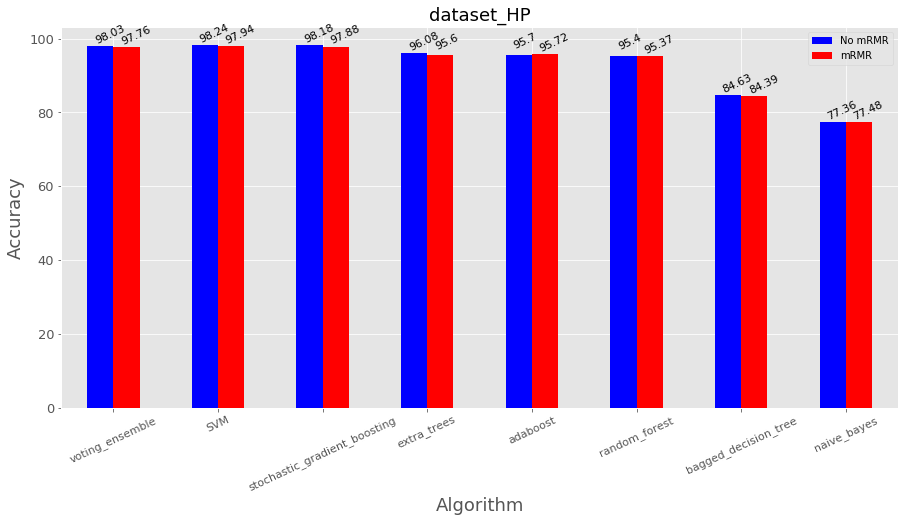

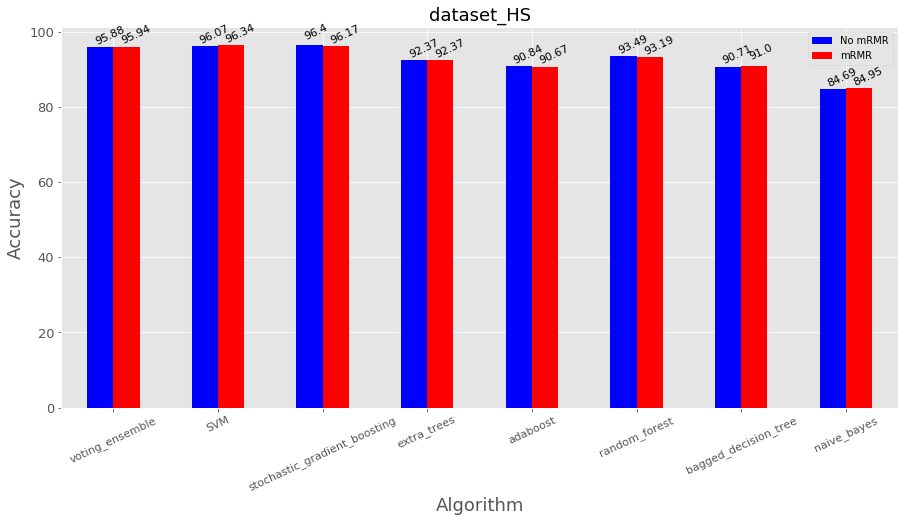

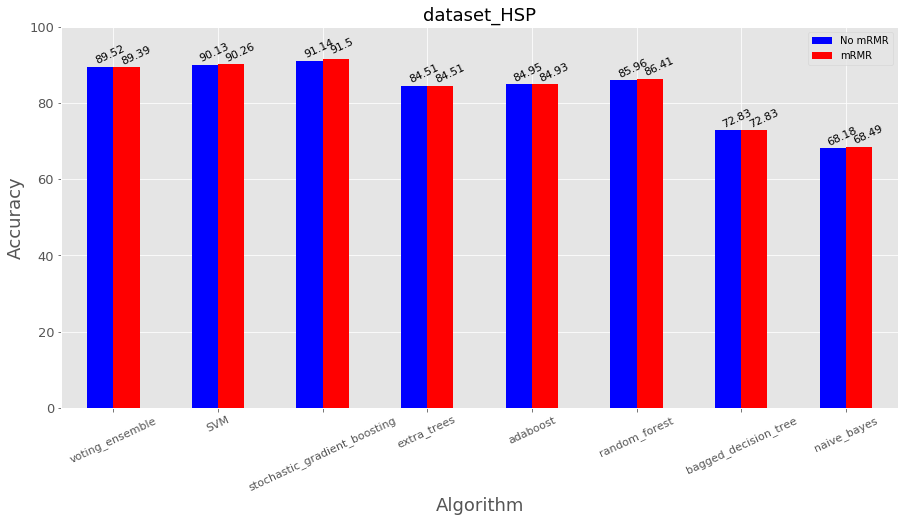

In [25]:
def mRMR_comparison(label, k_fold = None):
    for filename in files:
        non_mRMR_file = csv_directory + filename + '.csv'
        mRMR_file = feature_selection_csv_directory + filename + '.csv'
        
        df = pd.read_csv(non_mRMR_file)
        mRMR_df = pd.read_csv(mRMR_file)
        
        all_algorithms = algorithms + mRMR_algorithms
        accuracies = compute_accuracies(df, label, all_algorithms, k_fold)
        mRMR_accuracies = compute_accuracies(mRMR_df, label, all_algorithms, k_fold)
        
        comparison = []
        for algorithm in all_algorithms:
            comparison.append([accuracies[algorithm.__name__], mRMR_accuracies[algorithm.__name__]])
        
        comparison = zip(*comparison)
        comparison_df = pd.DataFrame({'No mRMR': comparison[0], 'mRMR': comparison[1]})
        
        ax = comparison_df[['No mRMR', 'mRMR']].plot(kind='bar',figsize=(15,7), color=['blue', 'red'], fontsize=13)
        ax.set_alpha(0.8)
        ax.set_title(filename, fontsize=18)
        ax.set_xlabel("Algorithm", fontsize=18)
        ax.set_ylabel("Accuracy", fontsize=18)
        ax.set_yticks([0, 20, 40, 60, 80, 100])
        ax.set_xticklabels(accuracies.keys(), rotation=25, fontsize=11)

        for i in ax.patches:
            ax.text(i.get_x()+.06, i.get_height()+4, str(round((i.get_height()), 2)), fontsize=11, rotation=25)
        
mRMR_comparison('label')